<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/Optimizer_HP_tuning_Clf_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [3]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import random

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [4]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [6]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [7]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [8]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train,y_train,10)
  return score

In [9]:
variance = np.linspace(0.5,1.5,101)
lengthscale = np.linspace(0.5,1.5,101)
x1,x2=np.meshgrid(variance,lengthscale)

In [10]:
def BO(var,l,clf):
  kernel = GPy.kern.Matern52(input_dim=1, variance=var, lengthscale=l)
  optimizer = GPyOpt.methods.BayesianOptimization(f=clf, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
          -0.5 * np.log(np.linalg.det(kernel.K(X)+(0.01**2)*np.identity(25))) - np.pi * 0.5 * np.log(2*np.pi)
  return log_mll

In [22]:
score_rf=[]
v_list=[]
l_list=[]
for i in range(30):
  v=random.choice(variance)
  v_list.append(v)
  l=random.choice(lengthscale)
  l_list.append(l)
  mll= BO(v,l,rf_score)
  score_rf.append(mll)

<AxesSubplot:>

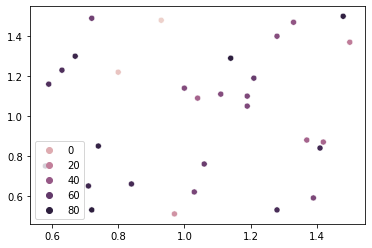

In [33]:
score_rf1=[ 5.67470612e+01,  4.21695723e+01,  4.97023545e+01,  5.15772349e+01,
        5.78650900e+01,  7.25733919e+01, -1.65340978e+01,  7.91410293e+01,
        7.01995389e+01,  7.63856948e+01,  7.84780509e+01, -1.10661921e+01,
        4.75217303e+01,  3.33601814e+01,  6.61695590e+01,  7.97637249e+01,
        2.15083714e+01,  6.87587055e+01,  5.46141492e+01,  8.00340760e+01,
        1.1e+01,  4.62256080e+01,  4.69509803e+01,  3.36981479e+01,
        5.05950726e+01,  7.18902641e+01,  4.92971296e+01,  3.26726536e+01,
        7.46087935e+01,  6.71256871e+01]
sns.scatterplot(x=v_list,y=l_list,hue=score_rf1)

In [34]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 100)}
      ]

def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

In [ ]:
score_SVM=[]
v_list=[]
l_list=[]
for i in range(30):
  v=random.choice(variance)
  v_list.append(v)
  l=random.choice(lengthscale)
  l_list.append(l)
  mll= BO(v,l,svm_score)
  score_SVM.append(mll)

<AxesSubplot:>

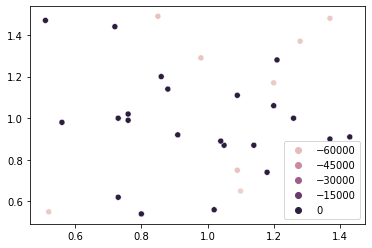

In [40]:
score_SVM = np.reshape(score_SVM,30)
sns.scatterplot(x=v_list,y=l_list,hue=score_SVM)

In [37]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]

def knn_score(parameters):
  params = {
        'leaf_size': parameters[0][0],
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  return score

<AxesSubplot:>

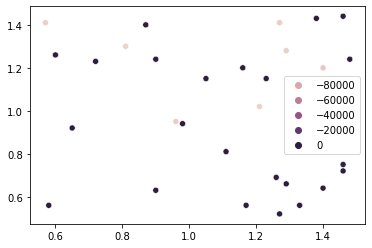

In [42]:
score_KNN=[]
v_list=[]
l_list=[]
for i in range(30):
  v=random.choice(variance)
  v_list.append(v)
  l=random.choice(lengthscale)
  l_list.append(l)
  mll= BO(v,l,knn_score)
  score_KNN.append(mll)

score_KNN=np.reshape(score_KNN,30)
sns.scatterplot(x=v_list,y=l_list,hue=score_KNN)